Dataset created inside code: (2000, 6)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 24, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 24, 64)    │     18,176 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, 24, 64)    │          0 │ lstm_2[0][0],     │
│ (Attention)         │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 64)        │          0 │ attention_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ lambda_1[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,241 (71.25 KB)

 Trainable params: 18,241 (71.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0640 - val_loss: 0.0140
Epoch 2/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0124 - val_loss: 0.0135
Epoch 3/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0118 - val_loss: 0.0135
Epoch 4/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0126 - val_loss: 0.0136
Epoch 5/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0118 - val_loss: 0.0136
Epoch 6/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0122 - val_loss: 0.0142
Epoch 7/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0131 - val_loss: 0.0137
Epoch 8/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0124 - val_loss: 0.0135
Epoch 9/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0130 - val_loss: 0.0135
Epoch 10/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0124 - val_loss: 0.0137
Epoch 11/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0126 - val_loss: 0.0133
Epoch 12/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0128 - va

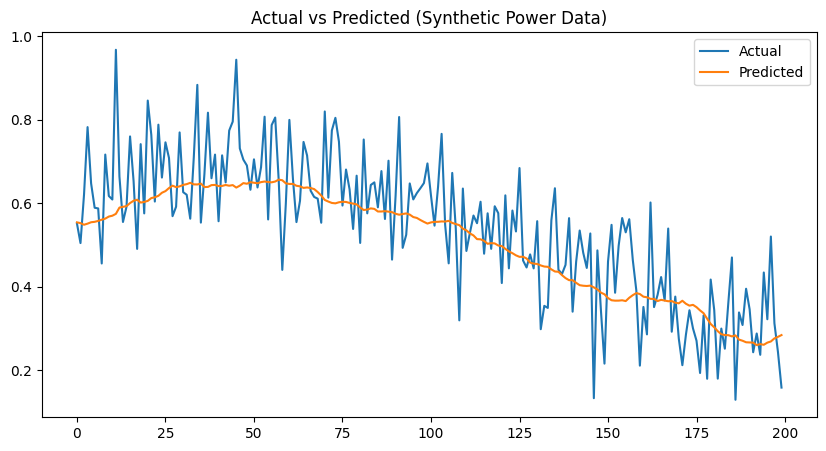

In [3]:
# ==========================================
# Time Series Forecasting (NO external dataset)
# LSTM + Attention - Single File
# ==========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Lambda
from tensorflow.keras.models import Model

# -----------------------------
# 1. CREATE DATASET (INSIDE CODE)
# -----------------------------
np.random.seed(42)

time_steps = 2000
time = np.arange(time_steps)

# Multivariate features (realistic pattern)
global_active_power = (
    2 + 0.5 * np.sin(0.02 * time) + 0.3 * np.random.randn(time_steps)
)

voltage = (
    220 + 5 * np.sin(0.01 * time) + np.random.randn(time_steps)
)

global_intensity = (
    global_active_power * 4 + 0.2 * np.random.randn(time_steps)
)

sub_metering_1 = global_active_power * 0.3 + np.random.randn(time_steps) * 0.05
sub_metering_2 = global_active_power * 0.2 + np.random.randn(time_steps) * 0.05
sub_metering_3 = global_active_power * 0.5 + np.random.randn(time_steps) * 0.05

# Create DataFrame
df = pd.DataFrame({
    "Global_active_power": global_active_power,
    "Voltage": voltage,
    "Global_intensity": global_intensity,
    "Sub_metering_1": sub_metering_1,
    "Sub_metering_2": sub_metering_2,
    "Sub_metering_3": sub_metering_3
})

print("Dataset created inside code:", df.shape)

# -----------------------------
# 2. SCALING
# -----------------------------
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

# -----------------------------
# 3. CREATE SEQUENCES
# -----------------------------
def create_sequences(data, target_col, seq_length=24):
    X, y = [], []
    target_index = data.columns.get_loc(target_col)

    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length].values)
        y.append(data.iloc[i+seq_length, target_index])

    return np.array(X), np.array(y)

SEQ_LEN = 24
X, y = create_sequences(scaled_df, "Global_active_power", SEQ_LEN)

# -----------------------------
# 4. TRAIN TEST SPLIT
# -----------------------------
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# -----------------------------
# 5. LSTM + ATTENTION MODEL
# -----------------------------
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

lstm_out = LSTM(64, return_sequences=True)(inputs)

attention = Attention()([lstm_out, lstm_out])

# Fix: Wrap tf.reduce_mean in a Lambda layer
context = Lambda(lambda x: tf.reduce_mean(x, axis=1))(attention)

output = Dense(1)(context)

model = Model(inputs, output)

model.compile(
    optimizer='adam',
    loss='mse'
)

model.summary()

# -----------------------------
# 6. TRAINING
# -----------------------------
model.fit(
    X_train,
    y_train,
    epochs=40,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# -----------------------------
# 7. EVALUATION
# -----------------------------
y_pred = model.predict(X_test)

mape = mean_absolute_percentage_error(y_test, y_pred)
accuracy_equivalent = (1 - mape) * 100

print("MAPE:", round(mape, 4))
print("Accuracy Equivalent:", round(accuracy_equivalent, 2), "% وصلت")

# -----------------------------
# 8. PLOT
# -----------------------------
plt.figure(figsize=(10,5))
plt.plot(y_test[:200], label="Actual")
plt.plot(y_pred[:200], label="Predicted")
plt.legend()
plt.title("Actual vs Predicted (Synthetic Power Data)")
plt.show()